# ADCP

Verificar: 'Exportando dados pelo WinRiver2.odt'... descreve o procedimento de exportação.

Dados foram corrigidos para o nível do transdutor e declinação magnética no Winriver2

Explicação sobre o procedimento de exportação dos dados pelo WinRiver no arquivo "Exportando dados pelo WinRiver2.odt"

### Importando Bibliotecas

##### Bibliotecas usadas a partir da primeira função

In [1]:
import pandas as pd
import numpy as np
from matplotlib.dates import num2date
import pytz

##### Biblioteca Usada na Regressão Linear

In [2]:
from scipy.stats import linregress

##### Bibliotecas Utilizadas no Mapa 1: Localização dos Ensembles

In [3]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

##### Bibliotecas Utilizadas no Mapa 2: Reta Ajustada e Ponto Projetado 

In [4]:
import geopandas as gpd
from shapely.geometry import Point, LineString

In [5]:
#### Outras
from matplotlib.colors import TwoSlopeNorm
import plotly.graph_objects as go
import plotly.express as px  # Biblioteca para visualização de dados interativos

### Define o Caminho dos Arquivos

In [6]:
# Caminho do arquivo com os dados
caminho_arquivo = "/home/ppms/Documents/TCC_Organizado/jp_notes_mb/dados/adcp_20210227_1.TXT"

In [7]:
# Caminho do basemap
basemap_path = '/home/ppms/Documents/TCC_Organizado/jp_notes_mb/dados/basemap_cNautica.tif'
basemap = rasterio.open(basemap_path)

### Funções 

#### Função de Leitura do Arquivo e Organização dos Dados 

In [8]:
def ler_dados_adcp(caminho_arquivo):
    """
    Função para ler os dados do arquivo ADCP em formato TXT e convertê-los em um DataFrame do pandas.

    Parameters:
    - caminho_arquivo (str): O caminho completo do arquivo TXT.

    Returns:
    - pd.DataFrame: DataFrame contendo os dados do arquivo ADCP.
    """
    
    try:
        # Definir os índices dos parâmetros
        indices = [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25]
    
        # Ler o arquivo TXT
        with open(caminho_arquivo, 'r') as arquivo:
            linhas = arquivo.readlines()
    
        # Criar listas vazias para armazenar os dados
        dados = {indice: [] for indice in indices}
    
        # Iterar sobre as linhas e extrair os dados
        for linha in linhas:
            valores = linha.split()
    
            for indice in indices:
                # Se o índice for de um parâmetro com valores separados por vírgula, dividir os valores
                if indice in [6, 7, 8, 9]:
                    valores_parametro = valores[indice].split(',')
                    dados[indice].append(valores_parametro)
                else:
                    dados[indice].append(valores[indice])
    
        # Criar o DataFrame usando o pandas
        df = pd.DataFrame(dados)
    
        # Renomear as colunas
        nomes_colunas = {
            0: 'ensemble',
            2: 'datahora',
            3: 'niveis',
            4: 'avgBack',
            5: 'porcentagem_bons',
            6: 'u',
            7: 'v',
            8: 'w',
            9: 'q',
            11: 'profundidade',
            12: 'qEnsemble',
            13: 'areaEnsemble',
            14: 'direcao_fluxo',
            15: 'direcao_rio',
            20: 'heading',
            21: 'pitch',
            22: 'roll',
            23: 'temperatura',
            24: 'latitude',
            25: 'longitude'
        }
    
        # Renomeando as colunas do DataFrame utilizando o dicionário de mapeamento
        # O dicionário 'nomes_colunas' contém as correspondências entre os nomes antigos e os novos das colunas
        # O parâmetro 'inplace=True' indica que a alteração deve ser feita no DataFrame original, sem a necessidade de atribuição
        df.rename(columns=nomes_colunas, inplace=True)
    
        # Converter a coluna datahora de unix para datetime
        df['datahora'] = df['datahora'].astype(float) / (24 * 3600)
        df['datahora'] = df['datahora'].apply(num2date)
    
        # Ajustar o fuso horário para o Sul do Brasil
        sul_brasil_tz = pytz.timezone('America/Sao_Paulo')
        df['datahora'] = df['datahora'].apply(lambda x: x.replace(tzinfo=sul_brasil_tz))
    
        # Converter strings para float e int nos parâmetros
        colunas_numericas = ['ensemble', 'u', 'v', 'w', 'q', 'qEnsemble', 'areaEnsemble', 'profundidade',
                              'direcao_fluxo', 'direcao_rio', 'heading', 'pitch', 'roll', 'temperatura', 'latitude', 'longitude']
    
        # Converter strings para float e int nos parâmetros
        df[colunas_numericas] = df[colunas_numericas].map(lambda x: pd.to_numeric(x, errors='coerce'))
    
        # Converter strings para float e int nos parâmetros
        for coluna in ['niveis', 'avgBack', 'porcentagem_bons']:
            df[coluna] = df[coluna].apply(lambda x: pd.to_numeric(x.split(','), errors='coerce'))
    
        
    
        def iterar_sobre_arranjo(arranjo):
            """
            Função para iterar sobre um arranjo, substituindo um valor específico por pd.NA.
        
            Parameters:
            - arranjo (list): O arranjo a ser iterado.
        
            Returns:
            - list: O arranjo resultante.
            """
            # Definindo o valor específico a ser substituído por pd.NA
            valor_especifico = -32768.0000
            
            # Usando uma list comprehension para iterar sobre o arranjo
            # Substituindo o valor específico por pd.NA, mantendo os outros valores inalterados
            resultado = [pd.NA if valor == valor_especifico else valor for valor in arranjo]
            
            # Retornando o arranjo resultante
            return resultado
    
        
        # Lista de colunas que serão processadas pela função iterar_sobre_arranjo
        colunas_flag = ['avgBack', 'u', 'v', 'w', 'q']
        
        # Iterando sobre cada coluna na lista
        for coluna in colunas_flag:
            # Aplicando a função iterar_sobre_arranjo a cada elemento da coluna
            df[coluna] = df[coluna].apply(iterar_sobre_arranjo)
    
        # Substituir -32768.0000 por pd.NA nas colunas especificadas
        colunas_substituir = ['qEnsemble', 'areaEnsemble', 'direcao_fluxo', 'direcao_rio', 'heading', 
                              'pitch', 'roll', 'temperatura', 'latitude', 'longitude']
        df[colunas_substituir] = df[colunas_substituir].replace(-32768.0000, pd.NA)
    
    
        # Iterar sobre os valores na coluna para que cada arranjo tenha 50 valores, completando com pd.NA
        for arranjo in df['q']:
            if len(arranjo) < 50:
                diff = 50 - len(arranjo)
                # Substituir np.nan por pd.NA
                arranjo.extend([pd.NA] * diff)
    
    
        # Retornando o dataframe com os dados
        return df

    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        return None

#### Função para Substituir pd.NA por np.nan

In [9]:
def NA4nan(df, column_name):
    """
    Função para substituir valores NA em uma coluna do DataFrame por nan e converter para um array numpy transposto.

    Args:
    - df: DataFrame contendo os dados.
    - column_name: Nome da coluna a ser processada e convertida.

    Returns:
    - Array numpy transposto com os valores processados.
    """
    # Inicializa uma lista vazia para armazenar os valores da coluna
    lst = []

    # Itera sobre os valores da coluna, substituindo valores NA por 'np.nan'
    for value in df[column_name].fillna(pd.NA).values:
        temp_lst = []
        # Itera sobre os elementos de cada lista dentro da coluna
        for i in value:
            # Verifica se o elemento é NA
            if i is pd.NA:
                # Se for NA, adiciona 'np.nan' à lista temporária
                temp_lst.append(np.nan)
            else:
                # Caso contrário, adiciona o valor atual à lista temporária
                temp_lst.append(i)
        # Adiciona a lista temporária à lista principal
        lst.append(temp_lst)

    # Converte a lista de listas em um array numpy transposto
    arr = np.array(lst).T
    return arr


#### Função que encontra o valor máximo absoluto num array multidimensional, ignorando valores NaN

In [10]:
def ValMax(arr):
    """
    Encontra o valor absoluto máximo em um array numpy, ignorando valores NaN.

    Args:
    - arr: Array numpy de entrada.

    Returns:
    - max_abs_index: Índice do valor absoluto máximo no array original.
    - max_abs_value: Valor absoluto máximo no array original.
    """
    # Aplaina o array e encontra o índice do valor absoluto máximo, ignorando NaN
    max_abs_index_flat = np.nanargmax(np.abs(arr))
    
    # Converte o índice aplainado para o índice correspondente no array original
    max_abs_index = np.unravel_index(max_abs_index_flat, arr.shape)
    
    # Encontra o valor absoluto máximo, ignorando NaN
    max_abs_value = np.abs(arr[max_abs_index])
    
    return max_abs_value

#### Função que calcula a média por intervalos de distância

In [11]:
def calcular_media_por_distancia(distancias, arr, d_dist):
    """
    Calcula a média do array fornecido para cada intervalo de distância.

    Parâmetros:
        distancias (ndarray): Array unidimensional contendo os valores de distância, em metros.
        arr (ndarray): Array multidimensional (células x ensemble) contendo os dados para os quais a média será calculada.
        d_dist (float): Intervalo de distância para a média, em metros.

    Retorna:
    
    Retorna:
        Tuple: Tupla contendo os resultados calculados (md_arr, md_dist).
        Sendo:
        md_arr (ndarray): Array multidimensional (células x ensemble) contendo as médias calculadas para cada intervalo de distância.
        dist_i (ndarray): Array unidimensional contendo as distâncias de referência dos dados promediados.
    """

    # Criar um array de classes de distância
    dist_classes = np.arange(0, np.max(distancias) + 10, d_dist)

    md_lst = []

    for i in range(1, len(dist_classes)):
        # Calcular os limites do intervalo de distância atual
        lower_bound = dist_classes[i-1]
        upper_bound = dist_classes[i]

        # Selecionar os índices onde a distância está dentro do intervalo atual
        idx = (distancias >= lower_bound) & (distancias < upper_bound)

        # Calcular a média do array para o intervalo atual
        md_lst.append(np.nanmean(arr.T[idx], axis=0))

    # Converter a lista em um array numpy
    md_arr = np.array(md_lst).T

    # Calcular as distâncias para cada intervalo
    dist_i = (dist_classes[1:] + dist_classes[:-1]) / 2

    return md_arr, dist_i

### Chama a Função de Leitura e Atribui o Dataframe a uma Variável

In [12]:
# Chamar a função para iniciar o processo de seleção de arquivo
df = ler_dados_adcp(caminho_arquivo)

# Excluir a primeira linha, que está comprometida
df = df[1:]

### Visualização Preliminar dos Dados

#### Mapa de Localização dos Ensembles e Seleção de Ensembles

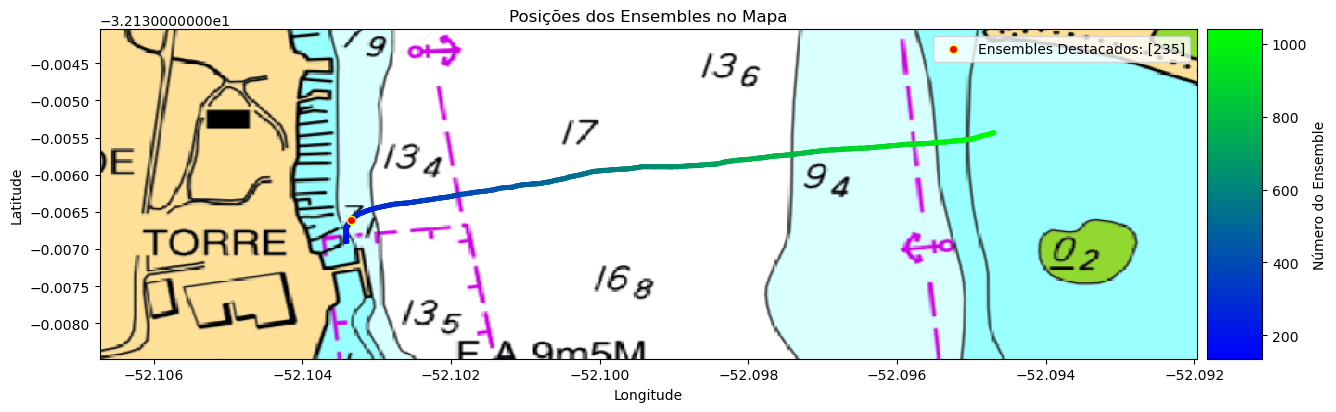

In [13]:
# Extraindo Coordenadas e Ensembles
longitude = df['longitude'].to_numpy()
latitude = df['latitude'].to_numpy()
ensemble_num = df['ensemble'].to_numpy()

# Substitua este valor pelo número do ensemble que você deseja destacar
ensembles_destacados = [235]

# Criar um mapa de cores personalizado
colors = [(0, 0, 1), (0, 1, 0)]  # valores RGB
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Crie uma figura e um eixo
fig, ax = plt.subplots(figsize=(15, 10))

# Mostre o basemap
show(basemap, ax=ax, cmap='Blues')

# Plote todos os ensembles
scatter = ax.scatter(longitude, latitude, c=ensemble_num, cmap=custom_cmap, s=7)

# Destaque os ensembles específicos
destacados_mask = np.isin(ensemble_num, ensembles_destacados)
scatter_destacados = ax.scatter(longitude[destacados_mask], latitude[destacados_mask], c='red',                                label=f'Ensembles Destacados: {ensembles_destacados}', edgecolors='yellow')

# Adicione uma legenda para os ensembles destacados

ax.legend()

# Adicione rótulos e título
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Posições dos Ensembles no Mapa')

# Ajuste o zoom manualmente
ax.set_xlim([basemap.bounds.left + 0.02, basemap.bounds.right - 0.028])
ax.set_ylim([basemap.bounds.bottom + 0.0105, basemap.bounds.top - 0.0135])

# Adicione uma barra de cores
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(scatter, cax=cax, label='Número do Ensemble')

# Exiba o gráfico
plt.show()


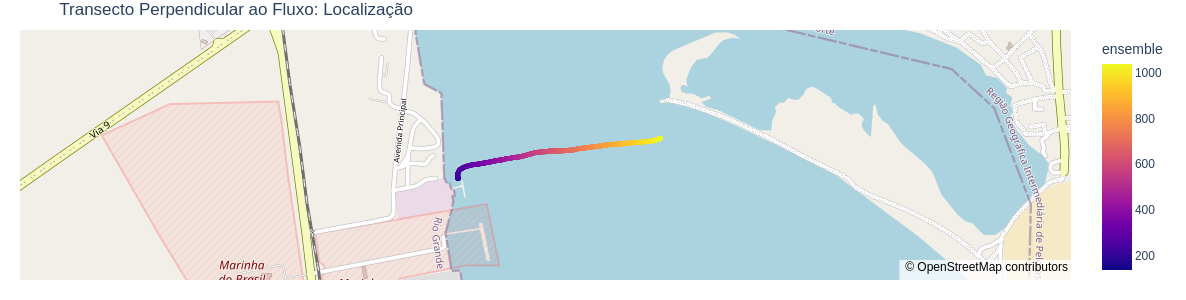

In [14]:
cor_palette = 'plasma'
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", hover_name='ensemble', zoom=14, height=300, 
                        color='ensemble', color_continuous_scale=cor_palette)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":20,"t":30,"l":20,"b":20},
                 title="Transecto Perpendicular ao Fluxo: Localização")

# Exibir o gráfico
fig.show()

In [15]:
# Variáveis não são mais necessárias e serão deletadas para liberar espaço
del longitude, latitude, ensemble_num

In [16]:
# Extraindo os Ensembles do Transecto Perpendicular ao Fluxo
df =  df.loc[(df['ensemble'] >= 235) & (df['ensemble'] <= df['ensemble'].max())]

### Plots corte vertical

In [17]:
# # Converter as colunas relevantes para arrays numpy
# avgBack = pd.Series(np.concatenate(df['avgBack'].values)).dropna()
# u = pd.Series(np.concatenate(df['u'].values)).dropna()
# v = pd.Series(np.concatenate(df['v'].values)).dropna()
# datahora = pd.Series(np.repeat(df['datahora'].values, 50))
# datahora = datahora.iloc[u.index.values]
# niveis = pd.Series(np.concatenate(df['niveis'].values)).dropna()
# niveis = niveis.iloc[u.index.values]

# # Criar DataFrame com as séries relevantes
# data = pd.DataFrame({'avgBack': avgBack, 'niveis': niveis, 'u': u, 'v': v, 'datahora': datahora})

In [18]:
# Extrai os valores do dataframe e substitui pb.NA por np.nan
# Isto é necessário por questão de compatibilidade com funções do numpy que serão usadas na sequência
u_arr = NA4nan(df, 'u')
v_arr = NA4nan(df, 'v')
avgB_arr = NA4nan(df, 'avgBack')

In [19]:
# Obter os valores únicos da coluna 'datahora' do DataFrame
unique_datetimes = np.unique(df.datahora)

# Obter os valores únicos da coluna 'niveis' do DataFrame e concatená-los em um único array
unique_niveis = np.unique(np.concatenate(df.niveis.values))

# Criar uma grade 2D de coordenadas X e Y usando os valores únicos de datahora e niveis
X, Y = np.meshgrid(unique_datetimes, unique_niveis)

In [20]:
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(X, -Y, u_arr, shading='auto')
# plt.colorbar(label='U Velocity')  # Add color bar with label
# plt.xlabel('Datetime')
# plt.ylabel('Depth')
# plt.title('Pseudocolor Plot of U Velocity')

# plt.plot(X.T, -df.profundidade.values, 'k')

# plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


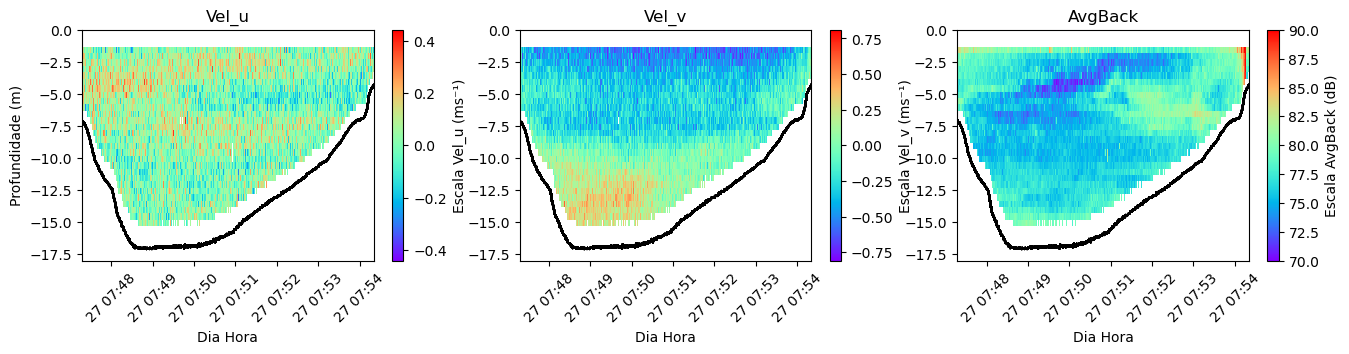

In [21]:
# Cria uma figura com três subplots horizontais
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Cria plots de pcolormesh
# Define a normalização de cores para o primeiro subplot
divnorm= TwoSlopeNorm(vmin=-1*ValMax(u_arr), vcenter=0, vmax=ValMax(u_arr))
# Plota o primeiro subplot com pcolormesh
p1 = axs[0].pcolormesh(X, -Y, u_arr, cmap='rainbow', norm=divnorm)

# Define a normalização de cores para o segundo subplot
divnorm= TwoSlopeNorm(vmin=-1*ValMax(v_arr), vcenter=0, vmax=ValMax(v_arr))
# Plota o segundo subplot com pcolormesh
p2 = axs[1].pcolormesh(X, -Y, v_arr, cmap='rainbow', norm=divnorm)

#OPCIONAL_Limitei só para visualizar como fica, pois tem um valor que destoa no canto direito
divnorm= TwoSlopeNorm(vmin=70, vcenter=80, vmax=90)
# Plota o terceiro subplot com pcolormesh
p3 = axs[2].pcolormesh(X, -Y, avgB_arr, cmap='rainbow', norm=divnorm)

# Define o rótulo do eixo y para o primeiro subplot
axs[0].set_ylabel('Profundidade (m)')

# Define os títulos dos subplots
titles = ['Vel_u', 'Vel_v', 'AvgBack']

# Define os rótulos da barra de cores
cbar_labels = ['Escala Vel_u (ms\u207B\u00B9)', 'Escala Vel_v (ms\u207B\u00B9)', 'Escala AvgBack (dB)']

# Loop sobre os subplots para adicionar detalhes
for i, ax in enumerate(axs):
    # Plota linhas verticais pretas para indicar a profundidade
    ax.plot(X.T, -df.profundidade.values, 'k')
    # Define o título do subplot
    ax.set_title(titles[i])
    # Define o rótulo do eixo x
    ax.set_xlabel('Dia Hora')
    # Define o limite do eixo y
    ax.set_ylim(-18, 0)
    # Rotaciona os rótulos do eixo x
    ax.tick_params(axis='x', labelrotation=45)
    # Adiciona a barra de cores ao subplot
    cbar = fig.colorbar([p1, p2, p3][i], ax=ax, orientation='vertical')
    # Define o rótulo da barra de cores
    cbar.set_label(cbar_labels[i])

# Exibe o gráfico
plt.show()

### Distância de Cada Ensemble de Um Ponto de Referência

#### Projeção de um ponto de referência a oeste usando regressão linear

In [22]:
# Convertendo os dados de longitude e latitude para arrays de float64
x = np.array(df.longitude).astype(np.float64)
y = np.array(df.latitude).astype(np.float64)

# Latitude média como referência para o ponto projetado
lat_ref = np.mean(y)

# Conversão da extensão, em km, de um grau de longitude para a latitude da área de estudo
# 111.12 km é a extensão de um grau de longitude no equador (40000km / 360graus)
conversao = 111.12 * np.cos(np.radians(lat_ref))

# Realize a regressão linear para obter os coeficientes
coeficientes = np.polyfit(x, y, 1)
slope = coeficientes[0]   # Inclinação da reta
intercept = coeficientes[1]   # Interceptação com o eixo y

# Configurando um ponto de referência na 'longitude'
xref = x.min() - 2/conversao  # Deslocamento de aproximadamente 2 km a oeste
yref = intercept + slope * xref  # Calculando a 'latitude' correspondente ao ponto de referência usando o modelo linear

ponto_projetado = (xref, yref)

In [23]:
# Calculando a diferença entre os dados de Longitude e Latitude em relação ao ponto de referência
dx = x - xref
dy = y - yref

# Calculando a distância euclidiana entre cada ensemble e o ponto de referência
# em quilômetros usando a conversão específica da latitude média dos dados
distancia_km = (dx**2 + dy**2)**.5 * conversao

# Ajustando a distancia para que seja em relação ao primeiro ensemble 
# E convertendo para metros
distancia = (distancia_km - np.min(distancia_km)) * 1000

# Adicionando ao dataframe
df['distancia'] = distancia


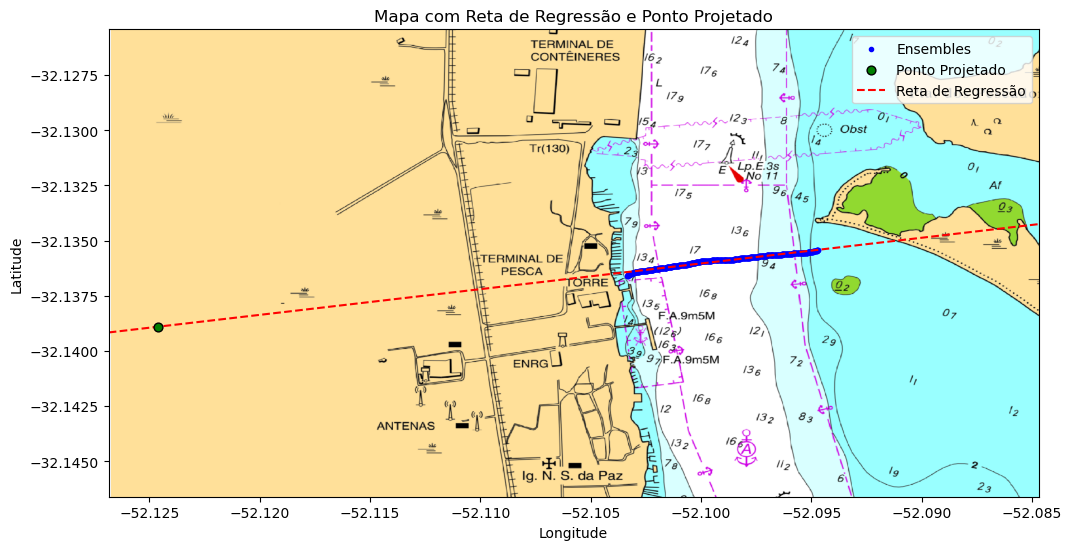

In [24]:
# Cria a função polinomial com base nos coeficientes da regressão linear
reta_regressao = np.poly1d(coeficientes)

# Cria uma linha representando a reta de regressão
# E estende a linha de regressão além dos pontos existentes
x_ext = np.linspace(min(x)-0.05, max(x)+0.05, 100)  # 100 pontos para a extensão
y_ext = reta_regressao(x_ext)
linha_regressao = LineString(list(zip(x_ext, y_ext)))

# Crie um GeoDataFrame para armazenar as geometrias
geometry = [Point(lon, lat) for lat, lon in zip(y, x)]
gdf = gpd.GeoDataFrame(geometry=geometry)

# Crie um GeoDataFrame para o ponto projetado
gdf_ponto = gpd.GeoDataFrame(geometry=[Point(ponto_projetado)])

# Crie um GeoDataFrame para a linha de regressão
gdf_linha = gpd.GeoDataFrame(geometry=[linha_regressao])

# Plote a nuvem de pontos, a reta de regressão e o ponto projetado
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, marker='.', color='blue', label='Ensembles')
gdf_ponto.plot(ax=ax, marker='o', color='g', label='Ponto Projetado', zorder=3, markersize=40, edgecolors='black')
gdf_linha.plot(ax=ax, color='red', linestyle='--', label='Reta de Regressão')


# Adicione rótulos e legendas
plt.title('Mapa com Reta de Regressão e Ponto Projetado')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Dê um zoom out ajustando os limites do gráfico
ax.set_xlim(min(x)-0.0235, max(x)+0.01)
ax.set_ylim(min(y)-0.01, max(y)+0.01)

# Mostre o basemap
show(basemap, ax=ax, cmap='Blues')

# Exiba o mapa
plt.show()


In [25]:
# Criar uma grade 2D de coordenadas X e Y usando os valores únicos de datahora e niveis
X, Y = np.meshgrid(df.distancia, unique_niveis)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


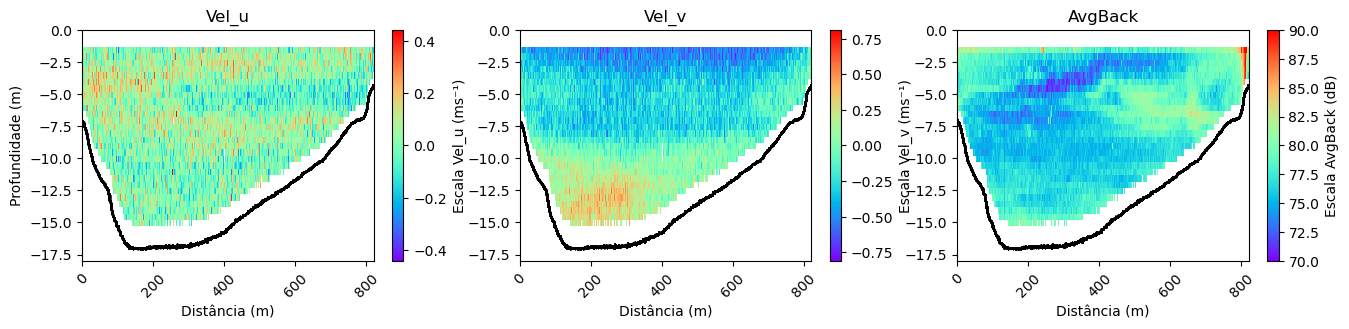

In [26]:
# Cria uma figura com três subplots horizontais
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Cria plots de pcolormesh
# Define a normalização de cores para o primeiro subplot
divnorm= TwoSlopeNorm(vmin=-1*ValMax(u_arr), vcenter=0, vmax=ValMax(u_arr))
# Plota o primeiro subplot com pcolormesh
p1 = axs[0].pcolormesh(X, -Y, u_arr, cmap='rainbow', norm=divnorm)

# Define a normalização de cores para o segundo subplot
divnorm= TwoSlopeNorm(vmin=-1*ValMax(v_arr), vcenter=0, vmax=ValMax(v_arr))
# Plota o segundo subplot com pcolormesh
p2 = axs[1].pcolormesh(X, -Y, v_arr, cmap='rainbow', norm=divnorm)

#OPCIONAL_Limitei só para visualizar como fica, pois tem um valor que destoa no canto direito
divnorm= TwoSlopeNorm(vmin=70, vcenter=80, vmax=90)
# Plota o terceiro subplot com pcolormesh
p3 = axs[2].pcolormesh(X, -Y, avgB_arr, cmap='rainbow', norm=divnorm)

# Define o rótulo do eixo y para o primeiro subplot
axs[0].set_ylabel('Profundidade (m)')

# Define os títulos dos subplots
titles = ['Vel_u', 'Vel_v', 'AvgBack']

# Define os rótulos da barra de cores
cbar_labels = ['Escala Vel_u (ms\u207B\u00B9)', 'Escala Vel_v (ms\u207B\u00B9)', 'Escala AvgBack (dB)']

# Loop sobre os subplots para adicionar detalhes
for i, ax in enumerate(axs):
    # Plota linhas verticais pretas para indicar a profundidade
    ax.plot(X.T, -df.profundidade.values, 'k')
    # Define o título do subplot
    ax.set_title(titles[i])
    # Define o rótulo do eixo x
    ax.set_xlabel('Distância (m)')
    # Define o limite do eixo y
    ax.set_ylim(-18, 0)
    # Rotaciona os rótulos do eixo x
    ax.tick_params(axis='x', labelrotation=45)
    # Adiciona a barra de cores ao subplot
    cbar = fig.colorbar([p1, p2, p3][i], ax=ax, orientation='vertical')
    # Define o rótulo da barra de cores
    cbar.set_label(cbar_labels[i])

# Exibe o gráfico
plt.show()

#### Suavizando os dados em função da distância

In [27]:
# Calcular as médias de profundidade para cada intervalo de distância
md_prof_arr = calcular_media_por_distancia(df.distancia, df.profundidade, 20)

# Calcular as médias de velocidade u para cada intervalo de distância
md_u_arr = calcular_media_por_distancia(df.distancia, u_arr, 20)

# Calcular as médias de velocidade v para cada intervalo de distância
md_v_arr = calcular_media_por_distancia(df.distancia, v_arr, 20)

# Calcular as médias de avgBackScatter para cada intervalo de distância
md_avgB_arr = calcular_media_por_distancia(df.distancia, avgB_arr, 20)

/tmp/ipykernel_6542/3656219662.py:33: RuntimeWarning:

Mean of empty slice



In [28]:
print(f'Shape profundidade: {md_prof_arr[0].shape}')
print(f'Shape Vel. u: {md_u_arr[0].shape}')
print(f'Shape avgB: {md_avgB_arr[0].shape}')

Shape profundidade: (41,)
Shape Vel. u: (50, 41)
Shape avgB: (50, 41)


In [29]:
md_u_arr[0]

array([[ 0.04488462, -0.02143478, -0.0283    , ...,  0.05929412,
         0.07595   ,  0.04668421],
       [ 0.06953846,  0.01708696,  0.01275   , ...,  0.05841176,
         0.0352    ,  0.06210526],
       [ 0.047     ,  0.08778261,  0.05615   , ...,  0.06264706,
        -0.0038    ,  0.01810526],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [30]:
# Criar uma grade 2D de coordenadas X e Y usando os valores de distância e níveis
X, Y = np.meshgrid(md_prof_arr[1], unique_niveis)

posx and posy should be finite values
posx and posy should be finite values


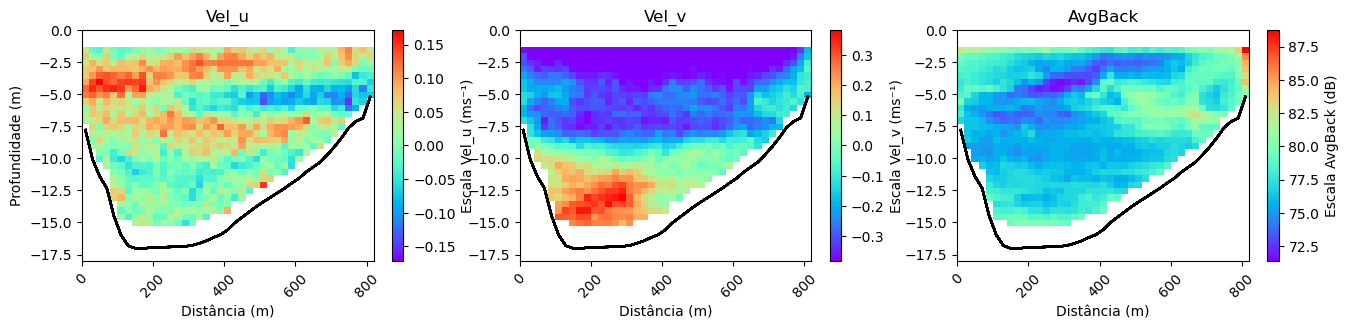

In [31]:
# Cria uma figura com três subplots horizontais
fig, axs = plt.subplots(1, 3, figsize=(16, 3))

# Cria plots de pcolormesh
# Define a normalização de cores para o primeiro subplot
divnorm_u = TwoSlopeNorm(vmin=-1 * np.nanmax(md_u_arr[0]), vcenter=0, vmax=np.nanmax(md_u_arr[0]))
# Plota o primeiro subplot com pcolormesh
p1 = axs[0].pcolormesh(X, -Y, md_u_arr[0], cmap='rainbow', norm=divnorm_u)

# Define a normalização de cores para o segundo subplot
divnorm_v = TwoSlopeNorm(vmin=-1 * np.nanmax(md_v_arr[0]), vcenter=0, vmax=np.nanmax(md_v_arr[0]))
# Plota o segundo subplot com pcolormesh
p2 = axs[1].pcolormesh(X, -Y, md_v_arr[0], cmap='rainbow', norm=divnorm_v)

# Define a normalização de cores para o terceiro subplot
# Plota o terceiro subplot com pcolormesh
p3 = axs[2].pcolormesh(X, -Y, md_avgB_arr[0], cmap='rainbow')

# Define o rótulo do eixo y para o primeiro subplot
axs[0].set_ylabel('Profundidade (m)')

# Define os títulos dos subplots
titles = ['Vel_u', 'Vel_v', 'AvgBack']

# Define os rótulos da barra de cores
cbar_labels = ['Escala Vel_u (ms\u207B\u00B9)', 'Escala Vel_v (ms\u207B\u00B9)', 'Escala AvgBack (dB)']

# Loop sobre os subplots para adicionar detalhes
for i, ax in enumerate(axs):
    # Plota linhas verticais pretas para indicar a profundidade
    ax.plot(X.T, -md_prof_arr[0], 'k')
    # Define o título do subplot
    ax.set_title(titles[i])
    # Define o rótulo do eixo x
    ax.set_xlabel('Distância (m)')
    # Define o limite do eixo y
    ax.set_ylim(-18, 0)
    # Rotaciona os rótulos do eixo x
    ax.tick_params(axis='x', labelrotation=45)
    # Adiciona a barra de cores ao subplot
    cbar = fig.colorbar([p1, p2, p3][i], ax=ax, orientation='vertical')
    # Define o rótulo da barra de cores
    cbar.set_label(cbar_labels[i])

# Exibe o gráfico
plt.show()


#### Rotação horizontal dos componentes da velocidade (u - transvesal & v - longitudinal)

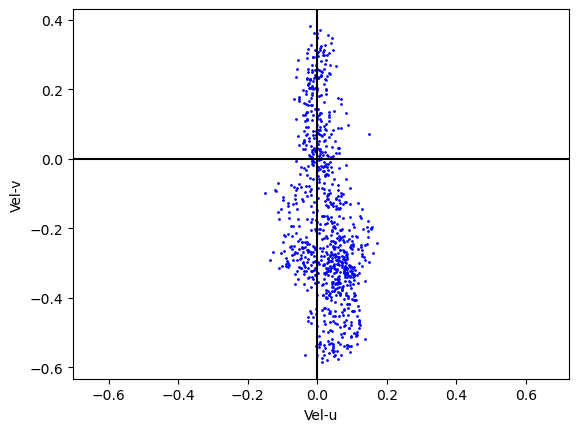

In [32]:
plt.plot(md_u_arr[0], md_v_arr[0], 'b.', ms=2)
plt.axis('equal')
plt.xlabel('Vel-u')
plt.ylabel('Vel-v')
plt.axvline(0, color='k')
plt.axhline(0, color='k')
plt.show()

#### A figura acima mostra ser desnecessário rotacionar

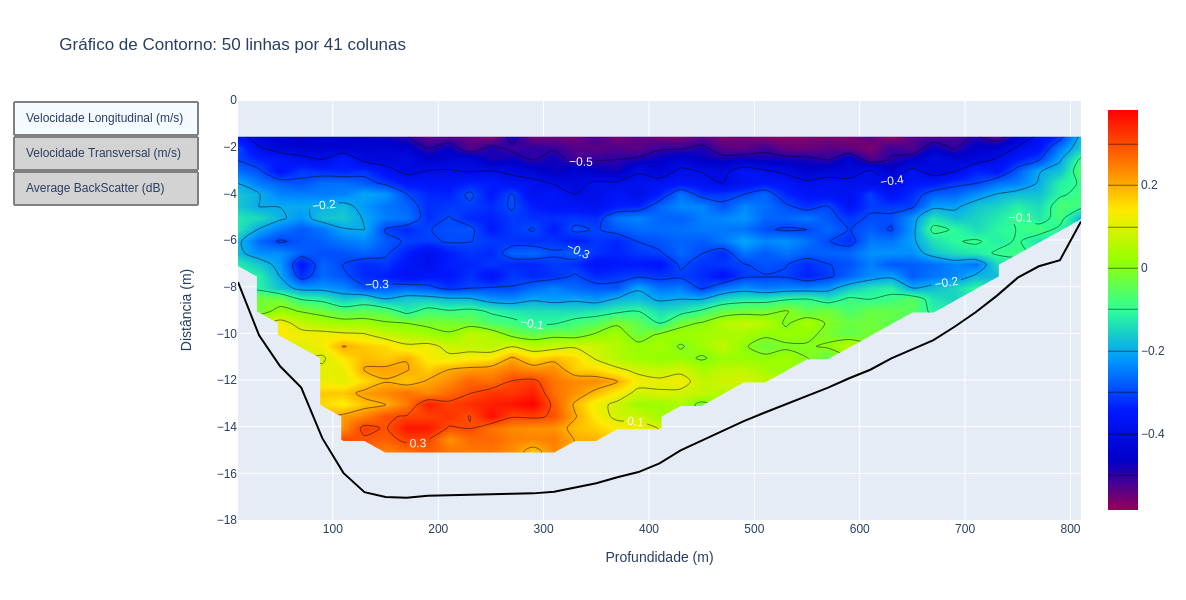

In [33]:
# Dados iniciais
dados_x = md_v_arr[1]
dados_y = -unique_niveis
dados_z = md_v_arr[0]

# Criar a figura inicial
fig = go.Figure(data=go.Contour(z=dados_z, x=dados_x, y=dados_y,
             
        line_smoothing=0.85,
        colorscale='Rainbow',
        colorbar=dict(
            #title='Barra de Cores',
            titleside='right',
            titlefont=dict(
                size=14,
                family='Arial, sans-serif')),
        contours=dict(
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white',
            ))
))

# Adicionar o fundo
fig.add_trace(go.Scatter(x=md_prof_arr[1], y=-md_prof_arr[0], mode='lines', name='Fundo', line=dict(color='black')))

# Adicionar título e rótulos dos eixos
fig.update_layout(title='Gráfico de Contorno: 50 linhas por 41 colunas', xaxis_title='Profundidade (m)', yaxis_title='Distância (m)')

# Definir os botões de alternância   md_temp_arr
buttons = []
for nome, dados_z in [('Velocidade Longitudinal (m/s)', md_v_arr[0]), 
                      ('Velocidade Transversal (m/s)', md_u_arr[0]),
                      ('Average BackScatter (dB)', md_avgB_arr[0])]:
    botao = dict(label=nome, method="update", args=[{"z": [dados_z]}])
    buttons.append(botao)

# Criar o menu suspenso
fig.update_layout(updatemenus=[dict(type="buttons", 
                                    buttons=buttons,
                                    bgcolor='lightgrey',  # Cor de fundo para o botão selecionado
                                    bordercolor='grey',   # Cor do contorno do botão selecionado
                                    borderwidth=2  )])

# Limitar o eixo y
fig.update_layout(yaxis=dict(range=[-18, 0]))  # Defina os limites

# Mudar as dimensões da figura
fig.update_layout(height=600, autosize=True)

# Exibir o gráfico
fig.show()


In [34]:
dados_y.shape

(50,)

In [35]:
dados_x = md_v_arr[1]
dados_y = -unique_niveis

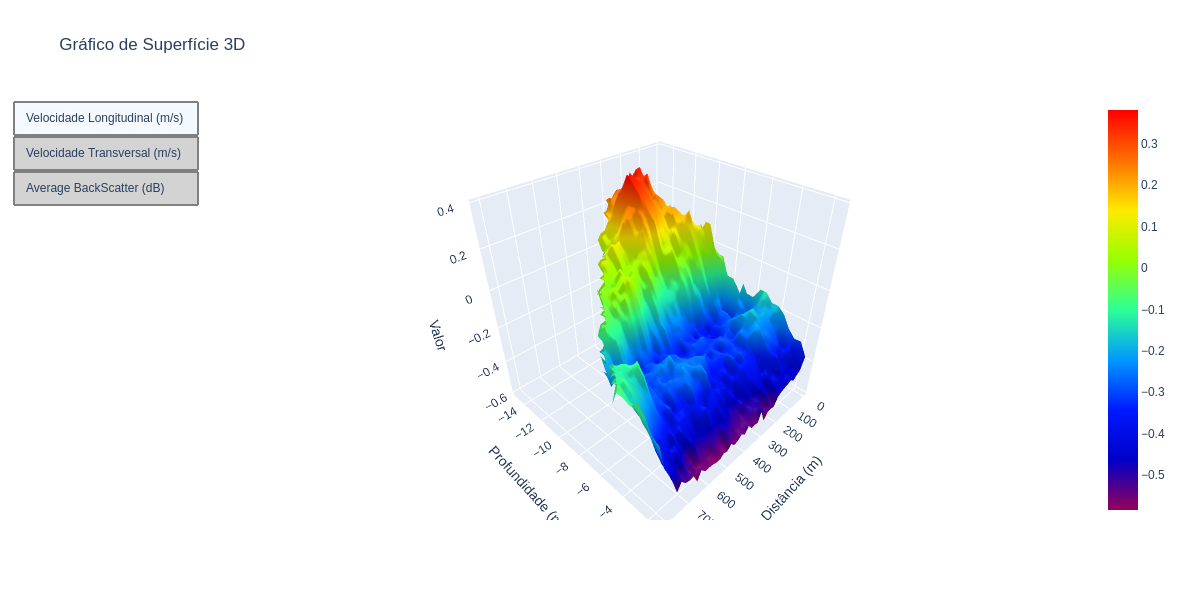

In [36]:
# Dados iniciais
dados_x = md_v_arr[1]
dados_y = -unique_niveis
dados_z = md_v_arr[0]

# Criar a figura inicial
fig = go.Figure(data=[go.Surface(z=dados_z, x=dados_x, y=dados_y,
                                
                                colorscale='Rainbow',
                                colorbar=dict(
                                    #title='Barra de Cores',
                                    titleside='right',
                                    titlefont=dict(
                                        size=14,
                                        family='Arial, sans-serif')))])

# Adicionar título e rótulos dos eixos
fig.update_layout(title='Gráfico de Superfície 3D', scene=dict(xaxis_title='Distância (m)', 
                                                               yaxis_title='Profundidade (m)',
                                                               zaxis_title='Valor'))

# Definir os botões de alternância
buttons = []
for nome, dados_z in [('Velocidade Longitudinal (m/s)', md_v_arr[0]), 
                      ('Velocidade Transversal (m/s)', md_u_arr[0]),
                      ('Average BackScatter (dB)', md_avgB_arr[0])]:
    botao = dict(label=nome, method="update", args=[{"z": [dados_z]}])
    buttons.append(botao)

# Criar o menu suspenso
fig.update_layout(updatemenus=[dict(type="buttons", buttons=buttons,
                                    bgcolor='lightgrey',  # Cor de fundo para o botão selecionado
                                    bordercolor='grey',   # Cor do contorno do botão selecionado
                                    borderwidth=2  )])

# Mudar as dimensões da figura
fig.update_layout(height=600, autosize=True)

# Exibir o gráfico
fig.show()
